<a href="https://colab.research.google.com/github/bksat90/FinalProject/blob/main/classification_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import pathlib
import PIL
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
# Import and mount Google Drive.
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
# # Unzip the dataset file and store it in a folder called images.
# !unzip "/content/drive/MyDrive/Project_BC/archive.zip" -d "/content/drive/MyDrive/Project_BC/cnn/"

In [6]:
label_dict = {'benign' : 0,
              'malignant' : 1}

def parse_image(filename):
  parts = tf.strings.split(filename, os.sep)
  label = parts[-2]
  label = tf.strings.to_number(label)

  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  return image, label

img_loc = "/content/drive/MyDrive/Project_BC/cnn/"

train_list_ds = tf.data.Dataset.list_files(img_loc + "train/*/*")
valid_list_ds = tf.data.Dataset.list_files(img_loc + "valid/*/*")

In [7]:
def img_process(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, size=[240,240])
  image = image / 255.0
  return image, label

In [8]:
train_ds = train_list_ds
val_ds = valid_list_ds

# parsing and processing the training images
train_ds = (
    train_ds
    .shuffle(1000)
    .map(parse_image)
    .map(img_process)
    .prefetch(tf.data.AUTOTUNE)
    .batch(128)
    .cache()
)

# parsing and processing the validation images
val_ds = (
    val_ds
    .map(parse_image)
    .map(img_process)
    .prefetch(tf.data.AUTOTUNE)
    .batch(128)
    .cache()
)

In [9]:
# input layer
input_layer = layers.Input(shape=(240, 240, 3), name='Input')

# convolutional layers
conv0 = layers.Conv2D(16, (5, 5), activation='relu', padding="same",
                      strides=(2, 2), name='Conv0')(input_layer)
conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding="same",
                      strides=(1, 1), name='Conv1')(conv0)
conv2 = layers.Conv2D(32, (3, 3), activation='relu', padding="same",
                      strides=(1, 1), name='Conv2')(conv1)
pool1 = layers.MaxPooling2D((2, 2), name='Pool1')(conv2)

conv3 = layers.Conv2D(64, (3, 3), activation='relu', padding="same",
                      strides=(1, 1), name='Conv3')(pool1)
conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding="same",
                      strides=(1, 1), name='Conv4')(conv3)
pool2 = layers.MaxPooling2D((2, 2), name='Pool2')(conv4)

conv5 = layers.Conv2D(128, (3, 3), activation='relu', padding="same",
                      strides=(1, 1), name='Conv5')(pool2)
conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding="same",
                      strides=(1, 1), name='Conv6')(conv5)
global_pool = layers.GlobalAveragePooling2D(name='GlobalPool')(conv6)

# fully connected layers
fc1 = layers.Dense(240, activation='relu', name='FC1')(global_pool)

# output layer
output_layer = layers.Dense(1, activation='sigmoid', name='Output')(fc1)

# create the model
model = models.Model(inputs=input_layer, outputs=output_layer)

In [10]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 320, 320, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv0 (Conv2D)                       │ (None, 160, 160, 16)        │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1 (Conv2D)                       │ (None, 160, 160, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, 160, 160, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool1 (MaxPooling2D)                 │ (None, 80, 80, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3 (Conv2D)                       │ (None, 80, 80, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv4 (Conv2D)                       │ (None, 80, 80, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool2 (MaxPooling2D)                 │ (None, 40, 40, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv5 (Conv2D)                       │ (None, 40, 40, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv6 (Conv2D)                       │ (None, 40, 40, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GlobalPool (GlobalAveragePooling2D)  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC1 (Dense)                          │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 358,529 (1.37 MB)

 Trainable params: 358,529 (1.37 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [12]:
# checkpoint_filepath = '/content/checkpoint/'

# checkpoint_callback = ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True
# )

In [13]:
# def scheduler(epoch, lr):
#     if epoch < 10:
#         return lr
#     else:
#         return lr * tf.math.exp(-0.01)

# lr_callback = LearningRateScheduler(scheduler)

In [14]:
epoch_num = 20

history = model.fit(train_ds, validation_data=val_ds, epochs=epoch_num)

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 806s 39s/step - accuracy: 0.6601 - loss: 0.6883 - val_accuracy: 0.6637 - val_loss: 0.6706
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 412ms/step - accuracy: 0.6488 - loss: 0.6628 - val_accuracy: 0.6637 - val_loss: 0.6579
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 363ms/step - accuracy: 0.6488 - loss: 0.6544 - val_accuracy: 0.6637 - val_loss: 0.6518
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 364ms/step - accuracy: 0.6488 - loss: 0.6511 - val_accuracy: 0.6637 - val_loss: 0.6498
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 362ms/step - accuracy: 0.6488 - loss: 0.6497 - val_accuracy: 0.6637 - val_loss: 0.6468
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 366ms/step - accuracy: 0.6488 - loss: 0.6482 - val_accuracy: 0.6637 - val_loss: 0.6439
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 350ms/step - accuracy: 0.6488 - loss: 0.6471 - val_accuracy: 0.6637 - val_loss: 0.6422
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 354ms/step - accuracy: 0.6488 - loss: 0.6467 - val_accuracy:

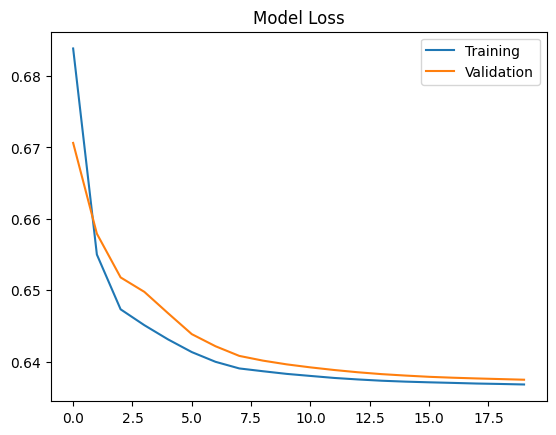

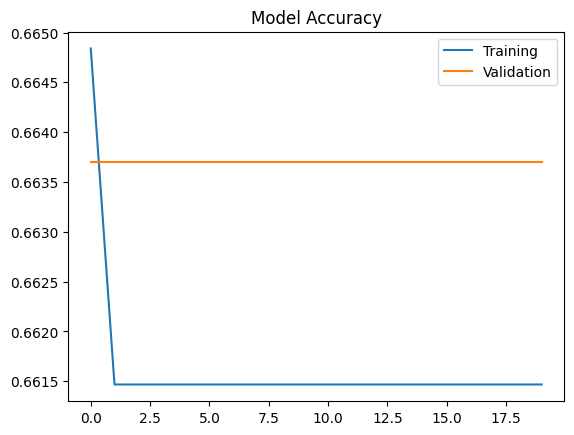

In [15]:
plt.figure()
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.title('Model Loss')

plt.figure()
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.title('Model Accuracy')

plt.show()